# 1.この課題の目的
スクラッチを通して決定木を理解する
複雑なアルゴリズムの実装に慣れる
以下の要件をすべて満たしていた場合、合格とします。

※Jupyter Notebookを使い課題に沿った検証や説明ができている。

# 2.スクラッチによる実装
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

決定木は分類と回帰双方に使用できますが、分類のみを扱います。

必須課題としては空間の分割を1回だけ行う、深さ1の決定木を作成します。それよりも深い決定木の作成はアドバンス課題とします。

# 【問題1】ジニ不純度を求める関数
まずは空間を分割するための指標値、ジニ不純度を計算する関数を作成してください。ノード$t$に対するジニ不純度$I(t)$
 は以下の数式で求まります。
 $$
 I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
 $$
 
 $t$ : ノードのインデックス

$i$ : クラスのインデックス

$K$ : クラスの数

$C_i$ : i番目のクラス

$P(C_i|t)$ :　t番目のノードにおける$C_i$の割合

$N_t,i$ : t番目のノードのi番目のクラスに属するサンプル数

$N_t,all$ : t番目のノードのサンプルの総数

まずは簡単な例を作り、手計算と関数の結果を比較してください。

例
- クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
- クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
- クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
- クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000
この他にもいくつか試してください。

## クラスのインポート

In [1]:
# クラス作成時に使用するクラス
import numpy as np
import pandas as pd

# ま前処理に使用するクラス
from sklearn.model_selection import train_test_split

# ScratchDecesionTreeClassifierクラス内で使用するクラス
from statistics import mode
from collections import Counter

# 評価指標のクラス
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# 決定領域を描画する際に使用するクラス
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## データ準備(シンプルデータセット1)

In [2]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

## データを分割

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 【問題1】ジニ不純度を求める関数
まずは空間を分割するための指標値、ジニ不純度を計算する関数を作成してください。ノード$t$に対するジニ不純度$I(t)$
 は以下の数式で求まります。
 $$
 I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
 $$
 
 $t$ : ノードのインデックス

$i$ : クラスのインデックス

$K$ : クラスの数

$C_i$ : i番目のクラス

$P(C_i|t) :　t番目のノードにおける$C_i$の割合

$N_t,i$ : t番目のノードのi番目のクラスに属するサンプル数

$N_t,all$ : t番目のノードのサンプルの総数

まずは簡単な例を作り、手計算と関数の結果を比較してください。

例
- クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
- クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
- クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
- クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000
この他にもいくつか試してください。

## compute_gini_impurityメソッド

In [4]:
def compute_gini_impurity(y):
    """
    ジニ不純度を計算
    Parameters
    ----------
    y : 次の形のndarray, shape(n_samples, 1)
        正解データ(分類ラベルのデータが格納)

    Returns
    -------
    gini_impurity : float
        ジニ不純度
    """

    # 正解データの合計を取得
    y_count = len(y)

    # 正解データから各ラベルを取得
    classes = np.unique(y)

    # ジニ不純度の初期値 1で設定
    gini_impurity = 1

    # 総和計算の結果を格納する変数(for文の中で計算結果を加算し続ける)
    total = 0

    # データの個数が0か判別
    if y_count == 0:

        # 0の場合→gini_impurity=０とする
        gini_impurity = 0


    else:

        # 0ではない場合　→　ジニ不純度を計算
        for _class in classes:

            # 各ラベルのそれぞれの個数を取得
            class_count = len(y[y == _class])

            # 総和計算を実施　→　total = total  + Σ（各ラベルの個数　/ ラベルの総数） ^2 
            total = total + (class_count / y_count)**2

        # ジニ不純度の計算 (１ −　Σ（各ラベルの個数　/ ラベルの総数） ^2 )
        gini_impurity = 1 - total

        return gini_impurity

## クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500

In [5]:
test_arr = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2])

In [6]:
Counter(test_arr)

Counter({1: 15, 2: 15})

In [7]:
compute_gini_impurity(test_arr)

0.5

## クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667

In [8]:
test_arr2 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,])

In [9]:
Counter(test_arr2)

Counter({1: 15, 2: 15, 3: 15})

In [10]:
compute_gini_impurity(test_arr2)

0.6666666666666667

## クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480

In [11]:
test_arr3 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2])

In [12]:
Counter(test_arr3)

Counter({1: 18, 2: 12})

In [13]:
compute_gini_impurity(test_arr3)

0.48

## クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

In [14]:
test_arr4 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

In [15]:
Counter(test_arr4)

Counter({1: 30})

In [16]:
compute_gini_impurity(test_arr4)

0.0

# 【問題2】情報利得を求める関数
次に、情報利得を計算する関数を作成してください。先ほど作成したジニ不純度 $I(t)$を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。
$$
IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$$

$p$ : 親ノードを示すインデックス

$left$ : 左側のノードを示すインデックス

$right$ : 右側のノードを示すインデックス

まずは簡単な例を作り、手計算と関数の結果を比較してください。

例

- 左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

この他にもいくつか試してください。

In [17]:
def compute_Information_gain(parent, left, right):
    """
    情報利得を計算
    Parameters
    ----------
    parent : 次の形のndarray, shape(n_samples, feature)
        特徴量データ

    left : 次の形のndarray, shape(左側のノードのサンプル数, feature)
        左側のノードのデータ

    right : 次の形のndarray, shape(右側のノードのサンプル数, feature)
        右側のノードのデータ    
    Returns
    -------
    information_gain : 次の形のndarray, shape (ラベル数, 1)
        各ラベル毎のジニ不純度
    """

    """
    ジニ不純度の計算
    """

    # 親ノードのジニ不純度の計算
    parent_gini = compute_gini_impurity(parent)

    # 左側のノードのジニ不純度の計算
    group1_gini = compute_gini_impurity(left)

    # 右側のノードのジニ不純度の計算
    group2_gini = compute_gini_impurity(right)

    """
    各データの個数を取得
    """
    # 親ノードのデータの個数
    parent_count = len(parent)

    # 左側のノードのデータの個数
    left_count = len(left)

    # 右側のノードのデータの個数
    right_count = len(right)

    """
    情報利得の計算
    """
    information_gain = parent_gini - ((left_count / parent_count) * group1_gini) \
                                    - ((right_count / parent_count) * group2_gini)

    return information_gain

## 左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

In [18]:
parent_node = np.array([1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,\
                        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2])

In [19]:
Counter(parent_node)

Counter({1: 30, 2: 35})

In [20]:
left_node = np.array([1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,])

In [21]:
Counter(left_node)

Counter({1: 10, 2: 30})

In [22]:
right_node = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2])

In [23]:
Counter(right_node)

Counter({1: 20, 2: 5})

In [24]:
compute_Information_gain(parent_node, left_node, right_node)

0.14319526627218937

# 【問題3】深さ1の決定木分類器クラスの作成
深さが1の決定機分類器のクラスを作成し、Sprint2で作成した分類のパイプラインに組み込んでください。

クラスの基本構造はSprint3の線形回帰を参考にし、名前は<font color="Red">ScratchDecesionTreeClassifier</font>としてください。

メソッドやパラメータなどはscikit-learnを参考にしてください。

[sklearn.tree.DecisionTreeClassifier — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

深さ1とは空間の分割を1回だけ行うことを指します。

<u>決定木のアルゴリズム</u>

ある特徴量の軸に対して、全てのパターンのしきい値を考え、それぞれの情報利得を計算していきます。各点の値をしきい値にする方法が一般的です。（ただし、実際にはしきい値の数は点の数よりひとつ少なくて良いことになります）分割の全候補の中で最も情報利得が大きくなるものをそのノードの分割方法として採用します。

ジニ不純度が0になるノード、または指定された深さのノードは葉と呼ばれます。葉にはそれぞれ推定時にどのクラスに分類するかを記録しておきます。ジニ不純度が0でない場合は、多数決により分類するクラスを決定します。

<u>ヒント</u>

これまでのスクラッチ課題に比べてアルゴリズムが複雑です。コードを書く前に、フローチャートなどで整理するようにしましょう。



In [25]:
class ScratchDecesionTreeClassifier():
    """
    決定木のスクラッチ実装

    Parameters
    ----------

    Attributes
    ----------
    self.classes_ : 次の形のndarray, shape (n_features,)
        クラスラベルのデータ
    self.n_classes_ : 次の形のndarray, shape (self.iter,)
        ラベル数
    self.current_threshold_index : tuple
        閾値のindex
    self.current_threshold_value : float
        閾値
    self.n_sample_ : int
        サンプルデータの数(データの行数)
    self.n_feature_ : int
        特徴量の数(データの列数)
    self.self.group1_index_ : list
        クラス1に分類した特徴量のindexが格納するリスト
    self.self.group2_index_ : list
        クラス2に分類した特徴量のindexが格納するリスト
    self.current_infomation_gain : float
        情報利得
    self.group1_gini = None : int
        グループ1のジニ不純度
    self.group2_gini = None : int
        グループ2のジニ不純度
    self.group1_majority : int
        グループ1の分類結果(学習の際に多数決で決まる)
    self.group2_majority : int
        グループ2の分類結果(学習の際に多数決で決まる)
      """

    def __init__(self):
        self.classes_ = None
        self.n_classes_ = None
        self.current_threshold_index_ = None
        self.current_threshold_value_ = None
        self.n_sample_ = None
        self.n_feature_ = None
        self.group1_index_ = None
        self.group2_index_ = None
        self.current_infomation_gain_ = None
        self.group1_gini_ = None
        self.group2_gini_ = None
        self.group1_majority_ = None
        self.group2_majority_ = None


    def fit(self, X, y):
        """
        深さが1の決定木分類機の最適な閾値を決める
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        """
        # 入力データの前処理
        
        # 入力データをnumpy配列に変換 →　dataframeが入力された場合も対応可能とする
        X = np.array(X)
        y = np.array(y)
        
        # 1次元の場合は、２次元に変換
        if X.ndim == 1:
            X = X[:, np.newaxis]
            
        # 最適な閾値を求める
        self.disitribute(X, y)

        return

    
    def predict(self, X):
        """
        入力データを２値分類する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        
        """
        
        # 予測値を計算(学習にて求めた最適な閾値を使用し、値が大きいか小さいかで入力データを分類する)
        # どの特徴量を使用するかは、閾値のindexを使用し、入力データから比較すべき特徴量列を抽出(X[:, self.current_threshold_index[1]の箇所)
        return np.where(X[:, self.current_threshold_index_[1]] > self.current_threshold_value_, self.group1_majority_, self.group2_majority_)
                

    def disitribute(self, X, y):
        """
        入力データから分類を行う為の最適な閾値を求める
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, 1)

        ----------
        """
        # 特徴量の行数を設定
        self.n_sample_ = len(X)
        
        # 特徴量の列数を設定
        self.n_feature_ = X.shape[1]
        
        # 情報利得の初期設定
        self.current_infomation_gain_ = 0
        
        # ジニ不純度の初期設定
        parent_gini = 0
        group1_gini = 0
        group2_gini = 0
        
        # 分類したサンプルのindexを格納するshape(0, 2)の空のnumpy配列を作成
        self.group1_index_ = []
        self.group2_index_ = []

        """
        閾値により分類開始
        """
        # 入力Xの列数までカウントアップ　→　比較する閾値の列方向のindexとなる
        for threshold_column in range(self.n_feature_):

            
            # 入力Xの行数までカウントアップ　→　比較する閾値の行方向のindexとなる
            for threshold_line in range(self.n_sample_):

                # 仮で設定した閾値の設定
                test_threshold_index = (threshold_line, threshold_column)
                self.group1_index_ = []
                self.group2_index_ = []
                
                # 入力Xの行数までカウントアップ　→　forが回るたびに1つindexの値を参照するようになる
                for comparison_line in range(self.n_sample_):

                    # 値を比較するデータのindex
                    comparison_index = (comparison_line, threshold_column)

                    # 仮で設定した閾値と値を比較
                    if X[comparison_index] > X[test_threshold_index]:
                        
                        # 閾値より値が高い→group1と判断しindexを格納
                        self.group1_index_.append(comparison_index[0])

                    else:

                        # 閾値より値が低い→group2と判断しindexを格納
                        self.group2_index_.append(comparison_index[0])

                """
                情報利得を比較
                """
                
                # 情報利得を計算
                test_infomation_gain = self.compute_Information_gain(y, y[self.group1_index_], y[self.group2_index_])

                # 現状で最も高い情報利得と値を比較
                if test_infomation_gain > self.current_infomation_gain_:
                    # 値が大きい　→　閾値、情報利得の値、閾値のindexを更新
                    self.current_infomation_gain_ = test_infomation_gain
                    self.current_threshold_index_ = test_threshold_index
                    self.current_threshold_value_ = X[self.current_threshold_index_]

                    # 各分類結果の多数決のクラスを取得
                    self.group1_majority_ = mode(y[self.group1_index_])
                    self.group2_majority_ = mode(y[self.group2_index_])
    
        return
    
    
    def compute_gini_impurity(self,y):
        """
        ジニ不純度を計算
        Parameters
        ----------
        y : 次の形のndarray, shape(n_samples, 1)
            正解データ(分類ラベルのデータが格納)
        
        label : ラベルのデータ型に準拠
            ジニ不純度を求めたいラベル(Noneであれば親ノードのジニ不純度を計算)
    
        Returns
        -------
        gini_impurity : float
            ジニ不純度
        """
    
        # 正解データの合計を取得
        y_count = len(y)
    
        # 正解データから各ラベルを取得
        classes = np.unique(y)
    
        # ジニ不純度を初期値 1で設定
        gini_impurity = 1
    
        # 総和計算の結果を格納する変数(for文の中で計算結果を加算し続ける)
        total = 0
        
        # データの個数が0か判別
        if y_count == 0:
            
            # 0の場合→gini_impurity=０とする
            gini_impurity = 0
        
        
        else:
            
            # 0ではない場合　→　gini_impurityを計算
            for _class in classes:

                # 各ラベルのそれぞれの個数を取得
                class_count = len(y[y == _class])

                # 総和計算を実施　→　total = total  + Σ（各ラベルの個数　/ ラベルの総数） ^2 
                total = total + (class_count / y_count)**2

            # ジニ不純度の計算 (１ −　Σ（各ラベルの個数　/ ラベルの総数） ^2 )
            gini_impurity = 1 - total

            return gini_impurity
    
    
    def compute_Information_gain(self,parent, left, right):
        """
        情報利得を計算
        Parameters
        ----------
        parent : 次の形のndarray, shape(n_samples, feature)
            親ノードのデータ
        left : 次の形のndarray, shape(左側のノードのサンプル数, feature)
            左側のノードのデータ
        right : 次の形のndarray, shape(右側のノードのサンプル数, feature)
            右側のノードのデータ    
        Returns
        -------
        information_gain : 次の形のndarray, shape (ラベル数, 1)
            各ラベル毎の情報利得
        """
    
        """
        ジニ不純度の計算
        """
    
        # 親ノードのジニ不純度の計算
        parent_gini = self.compute_gini_impurity(parent)
    
        # 左側のノードのジニ不純度の計算
        self.group1_gini = self.compute_gini_impurity(left)
    
        # 右側のノードのジニ不純度の計算
        self.group2_gini = self.compute_gini_impurity(right)
        
        """
        各データの個数を取得
        """
        # 親ノードのデータの個数
        parent_count = len(parent)

        # 左側のノードのデータの個数
        left_count = len(left)

        # 右側のノードのデータの個数
        right_count = len(right)
        
        # ジニ不純度がゼロとなったら(どちらか片方のグループに全ての特徴量が分類されたら)情報利得をゼロとする
        if left_count == 0 or right_count == 0:
            return 0

        """
        情報利得の計算
        """
        information_gain = parent_gini - ((left_count / parent_count) * self.group1_gini) \
                                        - ((right_count / parent_count) * self.group2_gini)

        return information_gain

In [26]:
cls = ScratchDecesionTreeClassifier()

In [27]:
cls.fit(X_train, y_train)

In [28]:
y_pred = cls.predict(X_test)

# 【問題6】指標値の算出
分類に関する指標値で精度を確認してください。

## Accuracy Score

In [29]:
print('accuracy_score = {}\n'.format(accuracy_score(y_test, y_pred)))

accuracy_score = 0.92



## Precision Score , Recall Score , F1 Score

In [30]:
target_names = ['class 1', 'class -1']

In [31]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.92      0.92      0.92        53
    class -1       0.91      0.91      0.91        47

   micro avg       0.92      0.92      0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



# 【問題7】決定領域の可視化
2値分類のデータセットに対して決定領域を可視化してください。

## 今回は2クラスの分類の為、2種類のマーカと色を用意

In [32]:
markers = ('s', 'x')
cmap = ListedColormap(('red', 'blue'))

## データの最小値と最大値を確認し、メッシュデータを0.01刻みで作成

In [33]:
x1_min, x1_max = X_test[:, 0].min()-1, X_test[:, 0].max()+1
x2_min, x2_max = X_test[:, 1].min()-1, X_test[:, 1].max()+1
x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                                   np.arange(x2_min, x2_max, 0.01))

## メッシュデータに対して作成したモデルで分類を実施

In [34]:
z = cls.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
z = z.reshape(x1_mesh.shape)

## 決定領域を表示

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


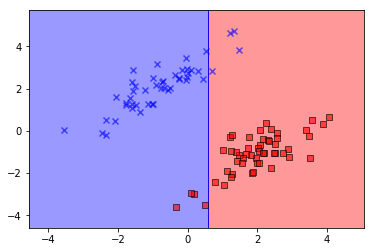

In [35]:
plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap=cmap)
plt.xlim(x1_mesh.min(), x1_mesh.max())
plt.ylim(x2_mesh.min(), x2_mesh.max())

for idx, cl in enumerate(np.unique(y_test)):
    plt.scatter(x=X_test[y_test == cl, 0],
                y=X_test[y_test == cl, 1],
                alpha=0.6,
                c=cmap(idx),
                edgecolors='black',
                marker=markers[idx],
                label=cl);

# 【問題8】決定木の利用場面
最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

決定木が他の手法に比べて有効だと考えられるのはどういった場面か
注意点

答えがある問いではありません。いろいろな視点から見て理解を深めていきましょう。

## ①機械学習についてあまり詳しくない人に分類のアルゴリズムを説明する場面
### そのように考えた理由→分類アルゴリズムが理解しやすい為
- 決定木の分類アルゴリズムは各特徴量の値と比較し大きいか小さいかで分類を行うという、他の分類アルゴリズム(ロジスティック回帰、SVM等)より、比較的理解しやすいアルゴリズムの為、業務等であまり機械学習に詳しくない人に分類アルゴリズムを説明する際に有効であると考えられる。

## ②視覚的にどのようなルールで分類されているのかを確認したい時
- scikit-learnのtreeクラスのgraphvizメソッドを使用することで決定木の表示ができ、この表示から視覚的にどのように分類されているのかを確認できる。この事は①と同様に機械学習に詳しくない人に対して分類アルゴリズムを説明する際に有効な手段であると考えられる。